In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys
print("Python version: {}". format(sys.version))
print("pandas version: {}". format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))
import seaborn as sns
print("numpy version: {}". format(np.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras import Sequential
from keras import utils
from keras.activations import sigmoid
le = LabelEncoder()

print('-'*25)
import os
print('\n'.join(os.listdir('input')))
print('-'*25)
        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Python version: 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
pandas version: 2.1.2
matplotlib version: 3.8.1
numpy version: 1.26.1
sklearn version: 1.3.2
-------------------------
test.csv
train.csv
gender_submission.csv
-------------------------


In [5]:
data_raworig = pd.read_csv("input/train.csv") #raw train data
data_testorig = pd.read_csv("input/test.csv") #Original test data
data_train = data_raworig.copy(deep = True)
data_train = data_train.set_index("PassengerId") #Train_data copied to protect raw train data 
data_test = data_testorig.copy(deep = True)
data_test = data_test.set_index("PassengerId") #Test_data copied to protect raw test data
Data = [data_train, data_test] #List of both datas to clean them simultaneous
print(data_train.shape)
print(data_test.shape)
print("Check train data:")
data_train.head()

(891, 11)
(418, 10)
Check train data:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Since we have 
    SibSp = Number of Spouse or Siblings
and 
    Parch = Number of Parents and Children for each passanger, 
it seems that a good data to have is Family Size. Lets check it:

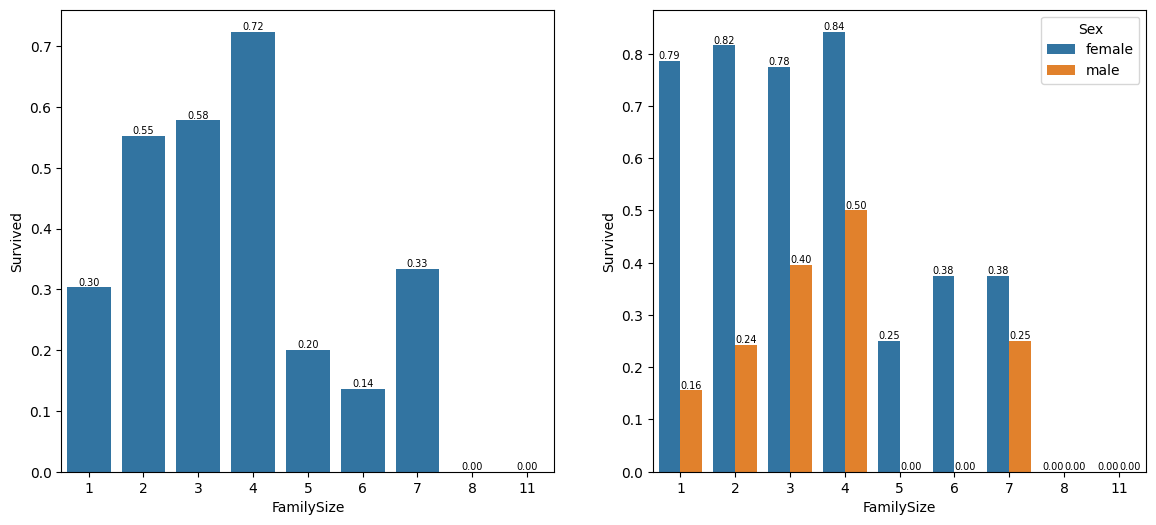

In [ ]:
for data in Data: #New variables to analyze
    data["Surname"] = data["Name"].str.split(",", expand=True)[0] #Surname of each passenger
    data["FamilySize"] = data["SibSp"]+data["Parch"]+1 #Family size on board
    data["Title"] = data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0] #Title of each person (Ex: Mr, Mrs., Miss., etc.)
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,6))
plotFamilySurvived1 = sns.barplot(x = "FamilySize", y = "Survived", data=data_train, ax=axis1, errorbar=None)
for container in plotFamilySurvived1.containers:
    plotFamilySurvived1.bar_label(container, fmt='%1.2f', fontsize=7);
plotFamilySurvived2 = sns.barplot(data = data_train, x = "FamilySize", y = "Survived", hue = "Sex", errorbar=None, ax = axis2);
for container in plotFamilySurvived2.containers:
    plotFamilySurvived2.bar_label(container, fmt='%1.2f', fontsize=7);

It appears that having a small family with children (3-4 family size) gives the best outcome to survive. Thus, we should define a variable which helps us identify these cases. In particular, we will consider three options: Alone, Small Family and Big Family.

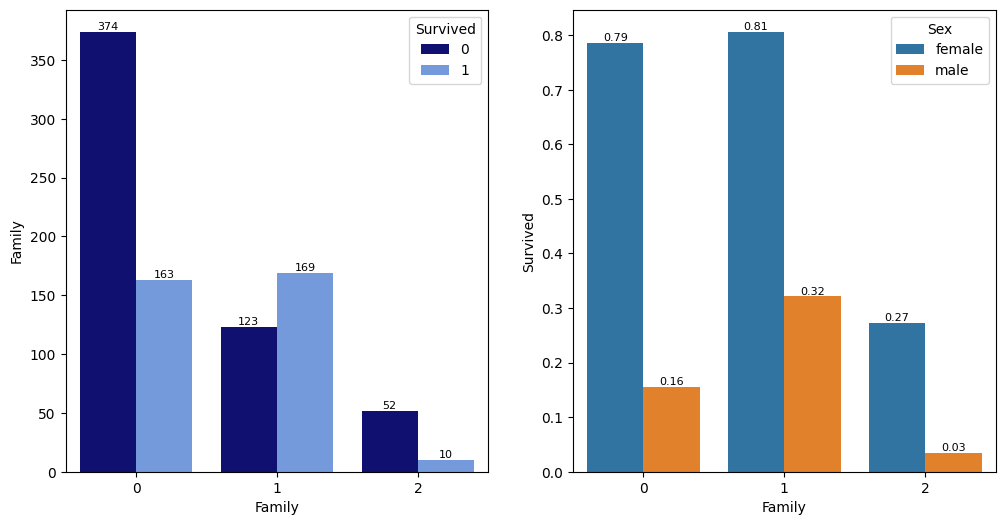

In [ ]:
for data in Data:
    data["Family"] = 0 #, 0 means Alone, 1 means Family of size between 2 and 4, 2 means Big Family
    data["Family"] = data["FamilySize"].apply(lambda x: 0 if x == 1 else (1 if 2 <= x <= 4 else 2))
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(12,6))
plotSmallFamilySurvived = sns.barplot(x = data_train["Family"], y = data_train["Family"], hue = data_train["Survived"], estimator=len, ax=axis1, palette=['navy', 'cornflowerblue'])
for container in plotSmallFamilySurvived.containers:
    plotSmallFamilySurvived.bar_label(container, fontsize=8)
hue_order = ["female", "male"]
plotSmallFamilySurvivedSex = sns.barplot(x = data_train["Family"], y = data_train["Survived"], hue = data_train["Sex"],hue_order = ["female", "male"], errorbar = None, ax=axis2)
for container in plotSmallFamilySurvivedSex.containers:
    plotSmallFamilySurvivedSex.bar_label(container, fmt='%1.2f', fontsize=8)

Thus, it is correct to assume that having an small family improves your chance of survival with being alone the second best option.

We need to fix the database now with the missing values.

In [ ]:
print("Null data on train:")
print(data_train.isnull().sum())
print('-'*25)
print("Null data in test:")
print(data_test.isnull().sum())
print('-'*25)

Null data on train:
Survived        0
Pclass          0
Name            0
Sex             0
Age           177
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked        2
Surname         0
FamilySize      0
Title           0
Family          0
dtype: int64
-------------------------
Null data in test:
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Cabin         327
Embarked        0
Surname         0
FamilySize      0
Title           0
Family          0
dtype: int64
-------------------------


There are 2 embarked missing on the Train data set. Let see if we can find a correlation between Embarking and Fare/PClass

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,FamilySize,Title,Family
PassengerId,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,1,Miss,0
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,1,Mrs,0


68

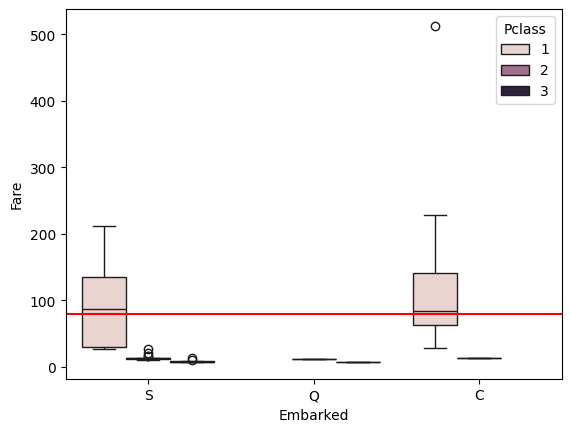

In [ ]:
display(data_train[pd.isnull(data_train["Embarked"]) == True])
display(data_train[(data_train["Sex"] == "female") & (data_train["Family"] == 0) & (data_train["Age"] > 18) & (data_train["Family"] == 0) & (data_train["Survived"] == 1)].shape[0])
sns.boxplot(data = data_train[(data_train["Sex"] == "female") & (data_train["Family"] == 0) & (data_train["Age"] > 18) & (data_train["Family"] == 0) & (data_train["Survived"] == 1)], x = "Embarked", y = "Fare", hue = "Pclass" )
plt.axhline(80, c='r');

It doesnt seems possible to conclude with security on which port they embarked. If we look at the total data, and just restrict ourselves to women of Pclass = 1 and Fare = 80, the best option is to assume that they Embarked in C or S. We will choose S.

In [ ]:
data_train["Embarked"].fillna("S", inplace = True)

What about Age?. We have 177 missing value on the Train data set. Can we obtain some kind of correlation with Fare and Pclass?

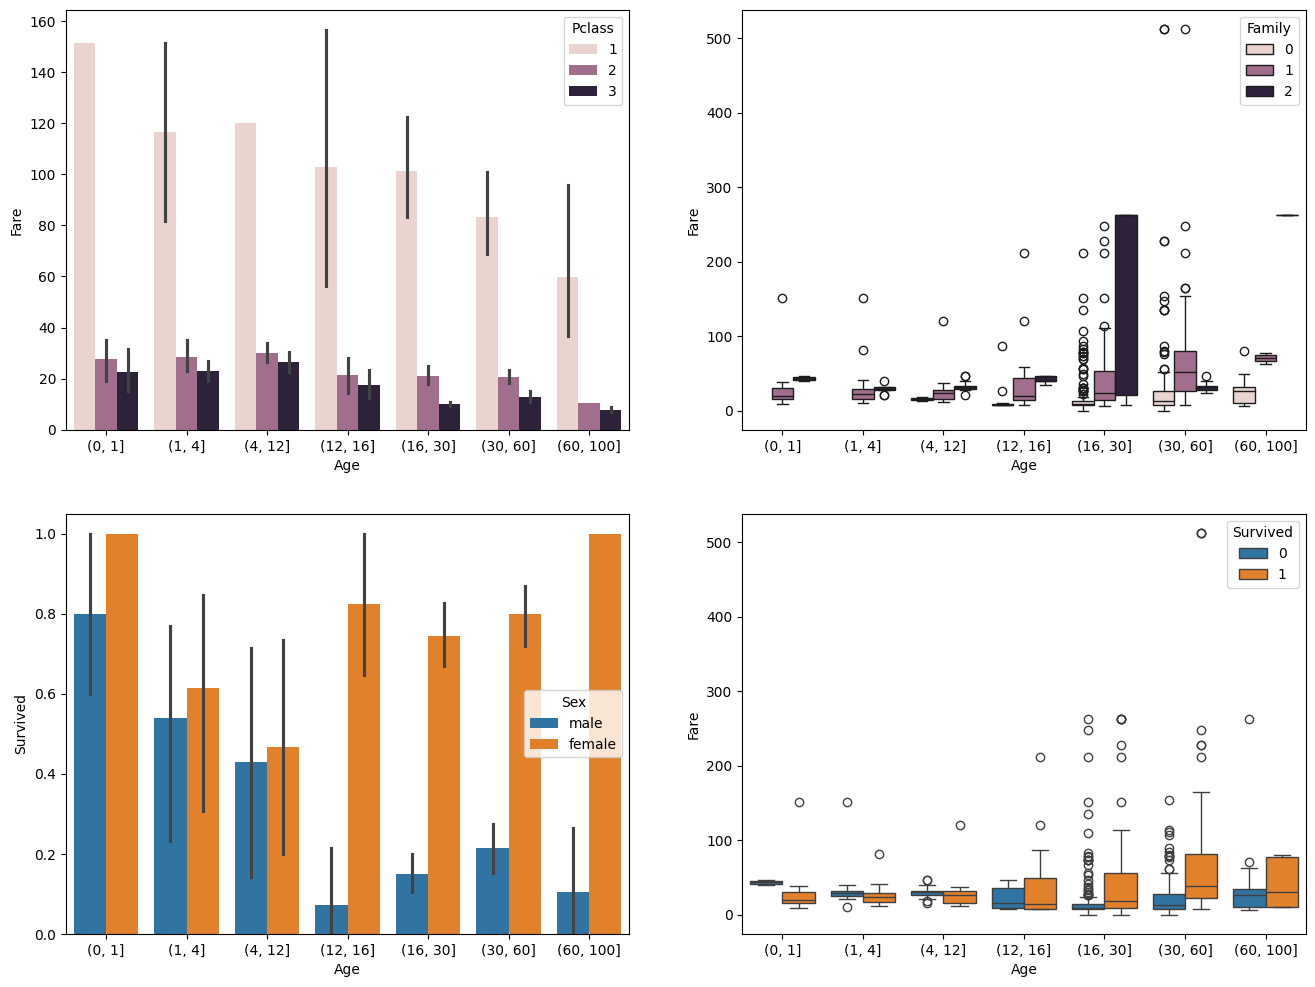

In [ ]:
fig, saxis = plt.subplots(2, 2,figsize=(16,12))
sns.barplot(data = data_train, y = "Fare" ,  x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), hue = "Pclass", ax = saxis[0,0] )
sns.barplot(data = data_train, x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = "Survived", hue = "Sex", ax = saxis[1,0] )
sns.boxplot(data = data_train, x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = "Fare", hue = "Family", ax = saxis[0,1] )
sns.boxplot(data = data_train, x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = "Fare", hue = "Survived", ax = saxis[1,1] );

It seems that there is no "smart" way to refill this data. We could try to use some kind of ML to do it. We will separate the age data into categories depending their stage of life. We will use the partition [0,1,4,13,16,30,60,100]

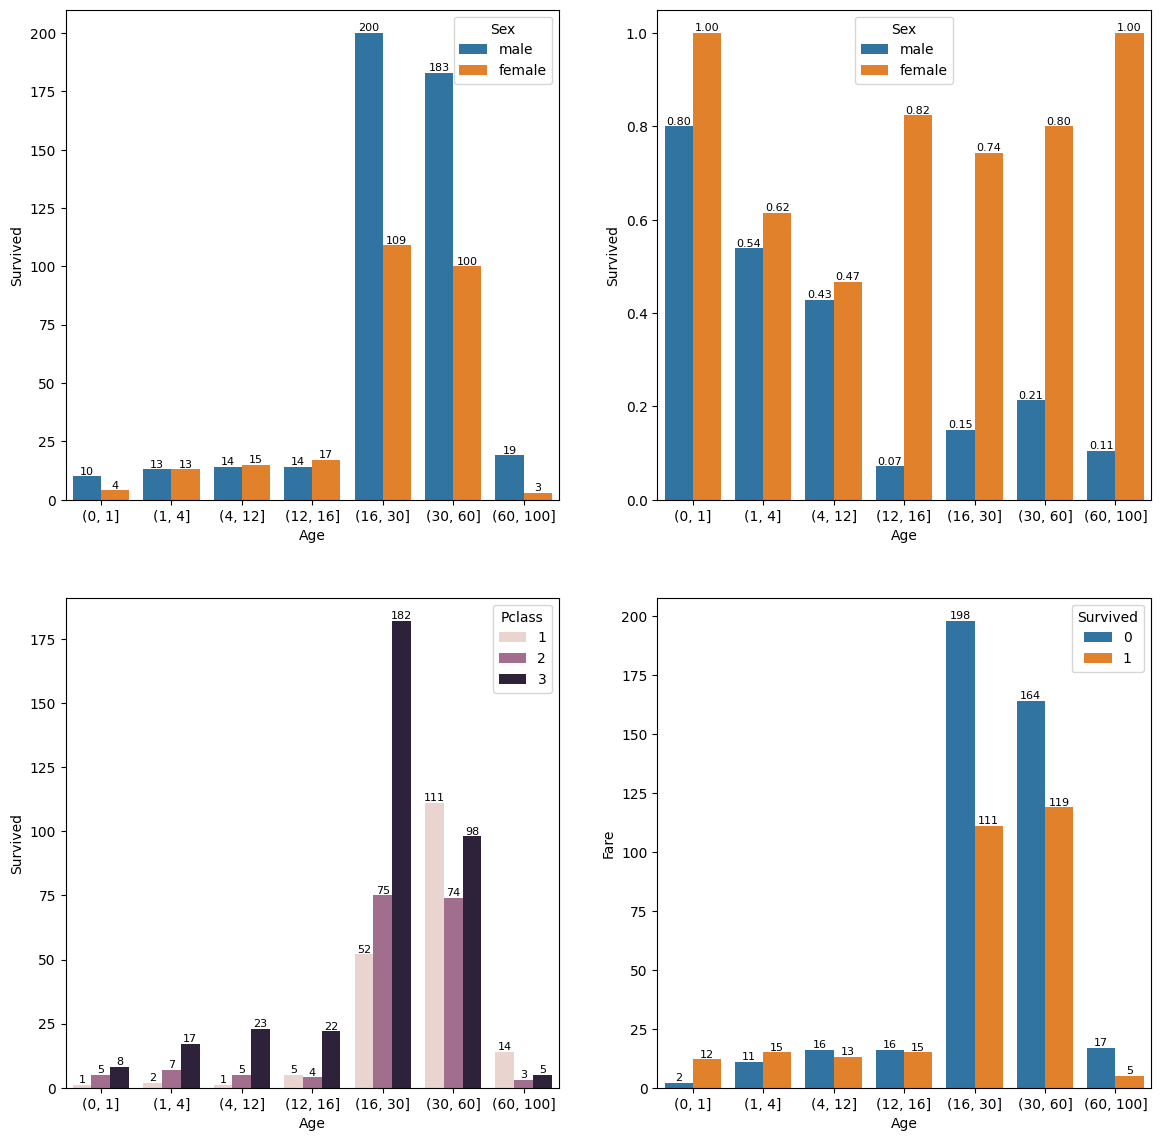

In [ ]:
fig, saxis = plt.subplots(2,2, figsize=(14, 14))
AgeSurvivedPlot = sns.barplot(x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = data_train["Survived"], hue = data_train["Sex"], estimator = len, errorbar = None, ax = saxis[0,0])
for container in AgeSurvivedPlot.containers:
    AgeSurvivedPlot.bar_label(container, fmt='%1.0f', fontsize=8)
AgeSurvivedPlot = sns.barplot(x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = data_train["Survived"], hue = data_train["Sex"], errorbar = None, ax = saxis[0,1])
for container in AgeSurvivedPlot.containers:
    AgeSurvivedPlot.bar_label(container, fmt = "%1.2f", fontsize=8)
AgeSurvivedPlot = sns.barplot(x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = data_train["Survived"], hue = data_train["Pclass"], estimator = len, errorbar = None, ax = saxis[1,0])
for container in AgeSurvivedPlot.containers:
    AgeSurvivedPlot.bar_label(container, fmt = "%1.0f", fontsize=8)
AgeSurvivedPlot = sns.barplot(x = pd.cut(data_train["Age"], [0,1,4,12,16,30,60,100]), y = data_train["Fare"], hue = data_train["Survived"], estimator = len, errorbar = None, ax = saxis[1,1]);
for container in AgeSurvivedPlot.containers:
    AgeSurvivedPlot.bar_label(container, fmt = "%1.0f", fontsize=8)

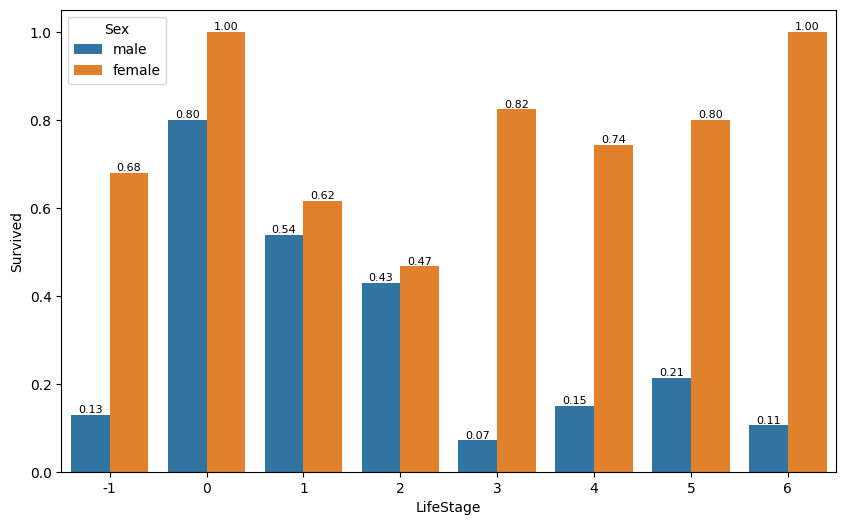

In [ ]:
def age_group_name(age):
    a = ""
    if age != age:
        a = -1
    elif age <= 1:
        a = 0
    elif age <= 4:
        a = 1
    elif age <=12:
        a = 2
    elif age <=16:
        a = 3
    elif age <=30:
        a = 4
    elif age <=60:
        a = 5
    else:
        a = 6
    return a
def age_group_number(age):
    a = ""
    if age == "Baby":
        a = 0
    if age == "Toddler":
        a = 1
    if age == "Child":
        a = 2
    if age == "Teenager":
        a = 3
    if age == "YoungAdult":
        a = 4
    if age == "YoungAdult":
        a = 5
    if age == "Senior":
        a = 6
    return a
for data in Data:
    data["LifeStage"] = data["Age"].apply(lambda x: age_group_name(x))
fig, ax = plt.subplots(figsize = (10,6))
LifeStageSurvived = sns.barplot(data = data_train, x = "LifeStage", y = "Survived", hue = "Sex",  errorbar=None);
for container in LifeStageSurvived.containers:
    LifeStageSurvived.bar_label(container, fmt='%1.2f', fontsize=8)

We still need to fix the missing Fare value on the test_data. He is a 60.5 years old male (Senior) of low class (Pclass = 3) which was traveling alone and embarked in Southampton. Thus, lets look at this data:

In [ ]:
print(data_test[(data_test["Pclass"] == 3) & (data_test["Embarked"] == "S")].groupby(["Embarked", "Pclass", "LifeStage", "Sex"])["Fare"].mean())

Embarked  Pclass  LifeStage  Sex   
S         3       -1         female    28.341150
                             male      13.434496
                   0         female    16.486100
                             male      12.508333
                   1         female    16.993750
                   2         female    46.900000
                             male      17.533325
                   3         female     7.650000
                             male      32.603125
                   4         female    12.379170
                             male       9.682033
                   5         female    12.923600
                             male      13.803289
                   6         male            NaN
Name: Fare, dtype: float64


Since he is the only Senior, we will use the Fare of male adults.

Lets analyze the Titles of the people and see if we can get some type of answer on the missing ages.

In [ ]:
display(data_train[pd.isnull(data_train["Age"]) == True])
print(data_train[pd.isnull(data_train["Age"]) == True].groupby(["Title", "Pclass", "Survived"]).size())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,FamilySize,Title,Family,LifeStage
PassengerId,,,,,,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Moran,1,Mr,0,-1
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,Williams,1,Mr,0,-1
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,Masselmani,1,Mrs,0,-1
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Emir,1,Mr,0,-1
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,O'Dwyer,1,Miss,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,Razi,1,Mr,0,-1
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,Sage,11,Miss,2,-1
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S,van Melkebeke,1,Mr,0,-1


Title   Pclass  Survived
Dr      1       0            1
Master  3       0            2
                1            2
Miss    1       1            1
        2       1            2
        3       0           14
                1           19
Mr      1       0           15
                1            5
        2       0            7
                1            2
        3       0           83
                1            7
Mrs     1       1            8
        3       0            3
                1            6
dtype: int64


In [ ]:
data_test["Fare"].fillna(13.803289, inplace = True)
print("Null data on train:")
print(data_train.isnull().sum())
print('-'*25)
print("Null data in test:")
print(data_test.isnull().sum())
print('-'*25)

Null data on train:
Survived        0
Pclass          0
Name            0
Sex             0
Age           177
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         687
Embarked        0
Surname         0
FamilySize      0
Title           0
Family          0
LifeStage       0
dtype: int64
-------------------------
Null data in test:
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin         327
Embarked        0
Surname         0
FamilySize      0
Title           0
Family          0
LifeStage       0
dtype: int64
-------------------------


There are a lot of missing data on Cabin to try to fix it correctly, thus we will drop it. Now, we will prepare and categorize our data to predict the age of the missing values. We already have categorized the Age and family size data. Let prepare the other important data.

In [ ]:
for data in Data:
    data["FareBin"] = pd.qcut(data["Fare"], 5) #Since Fare is float, we use quartile separation to map it to 0,1,2,3
for data in Data: #Gives each value of the variable a Category to give it a numerical value
    data["Sex_Calc"] = le.fit_transform(data["Sex"])
    data["Embarked_Calc"] = le.fit_transform(data["Embarked"])
    data["FareBin_Calc"] = le.fit_transform(data["FareBin"])
title_names = (data_train["Title"].value_counts() < 10) #Assigning True to titles which appears less than 10 times
for data in Data:
    data["Title"] = data["Title"].apply(lambda x: "Misc" if x not in title_names or title_names.loc[x] == True else x) #Removing odd title names with True assigned.
    data["Title_Calc"] = le.fit_transform(data["Title"])
data_x_calc = ["Pclass", "Sex_Calc", "Family", "SibSp", "Parch", "Embarked_Calc", "FareBin_Calc", "Title_Calc", "LifeStage"]
#We want to prepare data to compute Age. The strategy is the following: We will merge train+test data, and then separate them depending if LifeStage_Calc has a value or not.
#Then, we will train our model in the joint known data, to then predict separately on the missing data of train and test.
data_test_calc = data_test[data_x_calc].copy(deep = True) #The test_data we will use to predict LifeStage_Calc with LifeStage_Calc which will be popped.
data_train_calc = data_train[data_x_calc  + ["Survived"]].copy(deep = True) #The train_data we will use to predict LifeStage_Calc with LifeStage_Calc which will be popped.
data_test_calc["Survived"] = -1
#We join both data to make the prediction
data_life = pd.concat([data_test_calc, data_train_calc])
data_target_life = data_life[data_life["LifeStage"] == -1]
data_target_life = data_target_life.drop(["LifeStage"], axis = 1)
data_train_life_x = data_life[data_life["LifeStage"] != -1]
#Data on which we know LifeStage_Calc, which is the data on which we will train our model.
data_train_life_y = data_train_life_x.pop("LifeStage")
le.fit(data_train_life_y)
encoded_Y = le.transform(data_train_life_y) # convert integers to dummy variables (i.e. one hot encoded)
data_train_life_y = tf.keras.utils.to_categorical(encoded_Y, 7)
display(data_target_life)
display(data_train_life_x)
display(data_train_life_y)

,Pclass,Sex_Calc,Family,SibSp,Parch,Embarked_Calc,FareBin_Calc,Title_Calc,Survived
PassengerId,,,,,,,,,
902,3,1,0,0,0,2,1,3,-1
914,1,0,0,0,0,2,3,4,-1
921,3,1,1,2,0,0,3,3,-1
925,3,0,1,1,2,2,3,4,-1
928,3,0,0,0,0,2,1,2,-1
...,...,...,...,...,...,...,...,...,...
860,3,1,0,0,0,0,0,3,0
864,3,0,2,8,2,2,4,2,0
869,3,1,0,0,0,2,1,3,0


,Pclass,Sex_Calc,Family,SibSp,Parch,Embarked_Calc,FareBin_Calc,Title_Calc,Survived
PassengerId,,,,,,,,,
892,3,1,0,0,0,1,1,3,-1
893,3,0,1,1,0,2,0,4,-1
894,2,1,0,0,0,1,1,3,-1
895,3,1,0,0,0,2,1,3,-1
896,3,0,1,1,1,2,2,4,-1
...,...,...,...,...,...,...,...,...,...
886,3,0,2,0,5,1,3,4,0
887,2,1,0,0,0,2,2,1,0
888,1,0,0,0,0,2,3,2,1


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Let use sklearn to predict the values of the LifeStage_Calc.

In [ ]:
def neural_model():
	# create model
	model = keras.Sequential([
    keras.layers.Dense(256, activation = "relu", input_dim = 9),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(7, activation="softmax")
    ])
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

param_grid = {
    'max_depth': [5,10,20],
    'max_features' : [5,10,20],
    'n_estimators': [20,50]}

estimator = KerasClassifier(model=neural_model, epochs=50, batch_size=50, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, data_train_life_x, data_train_life_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/50
17/17 [==============================] - 12s 455ms/step - loss: 2.1068 - accuracy: 0.3792
Epoch 2/50
17/17 [==============================] - 3s 182ms/step - loss: 1.6756 - accuracy: 0.4892
Epoch 3/50
17/17 [==============================] - 1s 90ms/step - loss: 1.6162 - accuracy: 0.4761
Epoch 4/50
17/17 [==============================] - 1s 67ms/step - loss: 1.4840 - accuracy: 0.4928
Epoch 5/50
17/17 [==============================] - 2s 94ms/step - loss: 1.3318 - accuracy: 0.5431
Epoch 6/50
17/17 [==============================] - 1s 73ms/step - loss: 1.2575 - accuracy: 0.5467
Epoch 7/50
17/17 [==============================] - 1s 86ms/step - loss: 1.1928 - accuracy: 0.5443
Epoch 8/50
17/17 [==============================] - 1s 58ms/step - loss: 1.1827 - accuracy: 0.5490
Epoch 9/50
17/17 [==============================] - 1s 85ms/step - loss: 1.1329 - accuracy: 0.5646
Epoch 10/50
17/17 [==============================] - 1s 83ms/step - loss: 1.0613 - accuracy: 0.5610
Epoch 

With our trained model ready. We can predict the missing LifeStage of each person and we clean the databases we created to compute this.

Final_database for train data:

In [ ]:
estimator.fit(data_train_life_x, data_train_life_y)

data_train_final = data_train[data_x_calc+["Survived"]].copy(deep = True)
data_train_noage = data_train_final[data_train_final["LifeStage"] == -1]
missing_index = data_train_final[data_train_final["LifeStage"] == -1].index
not_missing_index = data_train_final[data_train_final["LifeStage"] != -1].index
data_train_noage = data_train_noage.drop(["LifeStage"], axis = 1)
display(data_train_final["LifeStage"])
data_train_final.loc[missing_index, "LifeStage"] = np.argmax(estimator.predict(data_train_noage), axis = -1)
display(data_train_final["LifeStage"].unique)

data_test_final = data_test[data_x_calc].copy(deep = True)
data_test_noage = data_test_final[data_test_final["LifeStage"] == -1]
missing_index = data_test_final[data_test_final["LifeStage"] == -1].index
data_test_noage = data_test_noage.drop(["LifeStage"], axis = 1)
data_test_noage["Survived"] = -1

data_test_final.loc[missing_index, "LifeStage"] = np.argmax(estimator.predict(data_test_noage), axis = -1)
display(data_test_final["LifeStage"].unique)


Epoch 1/50
21/21 [==============================] - 14s 459ms/step - loss: 2.0699 - accuracy: 0.3843
Epoch 2/50
21/21 [==============================] - 3s 149ms/step - loss: 1.7680 - accuracy: 0.4484
Epoch 3/50
21/21 [==============================] - 3s 122ms/step - loss: 1.5590 - accuracy: 0.4761
Epoch 4/50
21/21 [==============================] - 2s 117ms/step - loss: 1.4361 - accuracy: 0.5239
Epoch 5/50
21/21 [==============================] - 3s 123ms/step - loss: 1.3404 - accuracy: 0.5201
Epoch 6/50
21/21 [==============================] - 3s 133ms/step - loss: 1.2495 - accuracy: 0.5210
Epoch 7/50
21/21 [==============================] - 2s 104ms/step - loss: 1.1872 - accuracy: 0.5306
Epoch 8/50
21/21 [==============================] - 3s 147ms/step - loss: 1.1678 - accuracy: 0.5268
Epoch 9/50
21/21 [==============================] - 3s 123ms/step - loss: 1.1433 - accuracy: 0.5373
Epoch 10/50
21/21 [==============================] - 3s 138ms/step - loss: 1.1030 - accuracy: 0.535

PassengerId
1      4
2      5
3      4
4      5
5      5
      ..
887    4
888    4
889   -1
890    4
891    5
Name: LifeStage, Length: 891, dtype: int64

4/4 [==============================] - 2s 216ms/step


<bound method Series.unique of PassengerId
1      4
2      5
3      4
4      5
5      5
      ..
887    4
888    4
889    2
890    4
891    5
Name: LifeStage, Length: 891, dtype: int64>

2/2 [==============================] - 1s 325ms/step


<bound method Series.unique of PassengerId
892     5
893     5
894     6
895     4
896     4
       ..
1305    4
1306    5
1307    5
1308    4
1309    2
Name: LifeStage, Length: 418, dtype: int64>

Now that we have fixed the data, we can predict which people survive in the Titanic. We first review our data:

In [ ]:
print(data_train_final.shape)
data_train_final.head()

(891, 10)


,Pclass,Sex_Calc,Family,SibSp,Parch,Embarked_Calc,FareBin_Calc,Title_Calc,LifeStage,Survived
PassengerId,,,,,,,,,,
1,3,1,1,1,0,2,0,3,4,0
2,1,0,1,1,0,0,4,4,5,1
3,3,0,0,0,0,2,1,2,4,1
4,1,0,1,1,0,2,4,4,5,1
5,3,1,0,0,0,2,1,3,5,0


In [ ]:
print(data_test_final.shape)
data_test_final.head()

(418, 9)


,Pclass,Sex_Calc,Family,SibSp,Parch,Embarked_Calc,FareBin_Calc,Title_Calc,LifeStage
PassengerId,,,,,,,,,
892,3,1,0,0,0,1,1,3,5
893,3,0,1,1,0,2,0,4,5
894,2,1,0,0,0,1,1,3,6
895,3,1,0,0,0,2,1,3,4
896,3,0,1,1,1,2,2,4,4


In [ ]:
data_train_final_y = data_train_final.pop("Survived")
print(data_train_final_y)
model = Sequential()
model.add(Dense(256, input_shape=(9,), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(data_train_final, data_train_final_y, epochs=150, batch_size=10, verbose=0)

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64


In [ ]:
_, accuracy = model.evaluate(data_train_final, data_train_final_y)
print('Accuracy: %.2f' % (accuracy*100))
print(model.summary())

28/28 [==============================] - 8s 170ms/step - loss: 0.4476 - accuracy: 0.7856
Accuracy: 78.56
Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_622 (Dense)           (None, 256)               2560      
                                                                 
 batch_normalization_474 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dropout_422 (Dropout)       (None, 256)               0         
                                                                 
 dense_623 (Dense)           (None, 256)               65792     
                                                                 
 batch_normalization_475 (B  (None, 256)               1024      
 atchNormalization)                                              
             

In [ ]:
predictions = (model.predict(data_test_final) > 0.5).astype(int)
output = pd.DataFrame({'PassengerId': data_test.index, 'Survived': predictions.flatten()})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

14/14 [==============================] - 1s 42ms/step
Your submission was successfully saved!
